# Entraînement du modèle DistilBert sans régularisation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from transformers import DistilBertForSequenceClassification,DistilBertModel
from transformers import TFDistilBertForSequenceClassification,TFDistilBertModel
from transformers import DistilBertTokenizer,DistilBertTokenizerFast
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import os
from tensorflow.keras.layers import Dense,Dropout, Input
from tensorflow.keras import regularizers


In [3]:
train= pd.read_csv('emotion_train.txt',delimiter=';',header=None,names=['sentence','label'])
test= pd.read_csv ('emotion_test.txt',delimiter=';',header=None,names=['sentence','label'])
valid= pd.read_csv('emotion_val.txt',delimiter=';',header=None, names=['sentence','label'])

In [4]:
df=pd.concat([train,test,valid])

In [5]:
df.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# Encodage des variables catégorielles

In [6]:
df['encoded_labels'] = df['label'].astype('category').cat.codes

# Transformation de la variable sentence et encoded_labels en objet liste

In [7]:
data_text= df['sentence'].tolist()
data_label= df['encoded_labels'].tolist()

In [8]:
max_len=512
num_classes=len(df['label'].unique())
sentences=df['sentence'].tolist()
labels=df['encoded_labels']
len(sentences),len(labels)

(20000, 20000)

In [9]:
# Prepare the model input
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
input_ids=[]
attention_masks=[]

for sent in sentences:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

input_ids = np.asarray(input_ids)
attention_masks = np.array(attention_masks)
labels = np.array(labels)

/home/titontshiongo/anaconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Train_test_split

In [10]:
# split data 
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

train_label = np.array([np.array(val) for val in train_label])
val_label = np.array([np.array(val) for val in val_label])

In [1]:
train_inp.shape

NameError: name 'train_inp' is not defined

# Création du modèle DistilBert sans régularisation

In [13]:
# Distilbert sans régularisation
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    
    dbert_layer = dbert_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(512,activation='relu')(dbert_layer)
    
    #dense = Dense(64,activation='relu',)(dense)
    #taille 64: représentation latente des données
    #dense = Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dense)
    #dense = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dense)
    dropout= Dropout(0.5)(dense)
    
    pred = Dense(6, activation='softmax',)(dropout)
    
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    
    print(model.summary())
    return model   

2023-04-05 12:15:04.526315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-05 12:15:04.526354: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-05 12:15:04.526380: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (valnan): /proc/driver/nvidia/version does not exist
2023-04-05 12:15:04.526693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBe

In [14]:
model=create_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_1[0][0]',                
 BertModel)                     ast_hidden_state=(N               'input_2[0][0]']                
                                one, 512, 768),                                                   
                                 hidden_states=None                                           

In [16]:
#  learning rate recommandé pourl'optimizer Adam 5e-5, 3e-5, 2e-5: tiré du site Web huggingface

loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

early_stopping= EarlyStopping(patience=3,# stop après 3 epoch
                              monitor='val_loss',# regarder la val_loss
                              mode= 'min',
                              min_delta=0,# changement après 0
                              restore_best_weights=False,
                              verbose=1)

# Entraînement du modèle

In [17]:
model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
history=model.fit([train_inp,train_mask],train_label,batch_size=64,epochs=100,validation_data=([val_inp,val_mask],val_label),callbacks=early_stopping)

Epoch 1/10
250/250 [==============================] - 5986s 24s/step - loss: 0.6040 - accuracy: 0.7834 - val_loss: 0.1748 - val_accuracy: 0.9268
Epoch 2/10
250/250 [==============================] - 5827s 23s/step - loss: 0.1629 - accuracy: 0.9327 - val_loss: 0.1357 - val_accuracy: 0.9345
Epoch 3/10
250/250 [==============================] - 5727s 23s/step - loss: 0.1135 - accuracy: 0.9492 - val_loss: 0.1479 - val_accuracy: 0.9370
Epoch 4/10
250/250 [==============================] - 5722s 23s/step - loss: 0.0983 - accuracy: 0.9547 - val_loss: 0.1338 - val_accuracy: 0.9340
Epoch 5/10
250/250 [==============================] - 5720s 23s/step - loss: 0.0851 - accuracy: 0.9614 - val_loss: 0.1606 - val_accuracy: 0.9340
Epoch 6/10
250/250 [==============================] - 5720s 23s/step - loss: 0.0751 - accuracy: 0.9651 - val_loss: 0.1512 - val_accuracy: 0.9298
Epoch 7/10
250/250 [==============================] - 5721s 23s/step - loss: 0.0652 - accuracy: 0.9714 - val_loss: 0.1938 - val_ac

In [18]:
# sauvergade du modèle
model.save("myModel.h5")

# Pour charger le modèle sauvegardé
# from keras.models import load_model
# model_new = load_model("myModel.h5")

In [19]:
def plot_history(train_history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = train_history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

Lowest Validation Loss: epoch 4
Highest Validation Accuracy: epoch 3


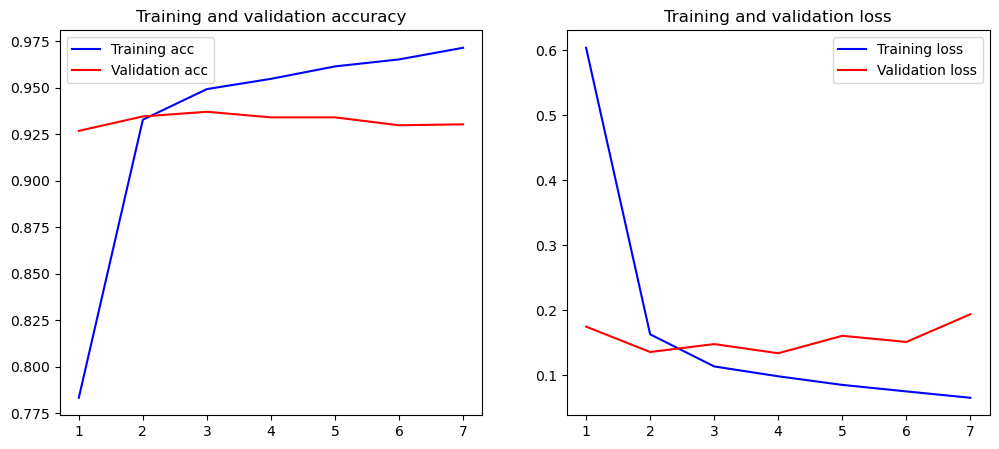

In [20]:

plot_history(history)

In [21]:
preds = model.predict([val_inp,val_mask],batch_size=16)

250/250 [==============================] - 488s 2s/step


In [25]:
pred_labels = preds.argmax(axis=1)

In [26]:
# Rapport de classification avec régularisation

target_names = ['anger', 'love', 'joy', 'fear', 'sadness', 'surprise']
print('Classification Report')
print(classification_report(val_label,pred_labels,target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       anger       0.94      0.92      0.93       527
        love       0.89      0.93      0.91       492
         joy       0.95      0.93      0.94      1326
        fear       0.77      0.90      0.83       291
     sadness       0.97      0.96      0.97      1207
    surprise       0.85      0.76      0.80       157

    accuracy                           0.93      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.93      0.93      0.93      4000



/tmp/ipykernel_35301/811949431.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


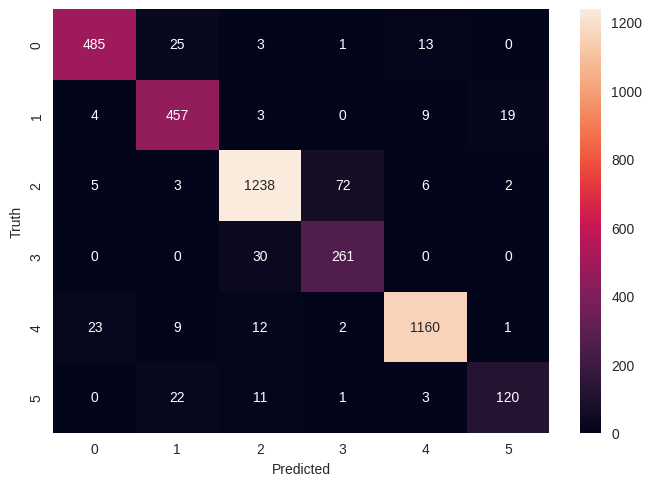

In [27]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

cm = confusion_matrix(val_label,pred_labels,)
# plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d',)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [28]:
val_inp.shape,val_label.shape,val_mask.shape

((4000, 512), (4000,), (4000, 512))

In [31]:
model.evaluate([val_inp, val_mask], val_label,batch_size=16,)

250/250 - 459s - loss: 0.1938 - accuracy: 0.9302 - 459s/epoch - 2s/step


[0.19380314648151398, 0.9302499890327454]

In [ ]:
model.evaluate([X_test, att_masks_test], y_test, batch_size=32, verbose=0)